# Using Progressive Growing GAN

Today we will show some basic commands to use Progressive GAN.

## 0 Prepare libraries

In [1]:
%tensorflow_version 1.x

!pip install -U -q PyDrive
!git clone https://github.com/tkarras/progressive_growing_of_gans.git
!pip install numpy==1.16
!pip install tqdm
%cd progressive_growing_of_gans

TensorFlow 1.x selected.
Cloning into 'progressive_growing_of_gans'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 350.61 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (79/79), done.
     |████████████████████████████████| 17.3MB 219kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: umap-learn 0.4.3 has requirement numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


/content/progressive_growing_of_gans


In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '188K19ucknC6wg1R6jbuPEhTq9zoufOx4' # karras2018iclr-celebahq-1024x1024.pkl 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('karras2018iclr-celebahq-1024x1024.pkl')


In [0]:
!ls

config.py			       misc.py
dataset.py			       networks.py
dataset_tool.py			       README.md
karras2018iclr-celebahq-1024x1024.pkl  representative_image_512x256.png
legacy.py			       requirements-pip.txt
LICENSE.txt			       tfutil.py
loss.py				       train.py
metrics				       util_scripts.py


## 1 Dataset creation / download

We will first have to re-cook the input image data into their own dataset file representation.

In [0]:
!mkdir datasets

In [0]:
!ls

config.py			       misc.py
dataset.py			       networks.py
datasets			       README.md
dataset_tool.py			       representative_image_512x256.png
karras2018iclr-celebahq-1024x1024.pkl  requirements-pip.txt
legacy.py			       tfutil.py
LICENSE.txt			       train.py
loss.py				       util_scripts.py
metrics


In [0]:
# Custom data?

#   tfrecord_dir       New dataset directory to be created
#   image_dir          Directory containing the images
!python dataset_tool.py create_from_images -h
#!python dataset_tool.py create_from_images datasets/CustomDataset CustomDataSource

usage: dataset_tool.py create_from_images [-h] [--shuffle SHUFFLE]
                                          tfrecord_dir image_dir

Create dataset from a directory full of images.

positional arguments:
  tfrecord_dir       New dataset directory to be created
  image_dir          Directory containing the images

optional arguments:
  -h, --help         show this help message and exit
  --shuffle SHUFFLE  Randomize image order (default: 1)

Example: dataset_tool.py create_from_images datasets/mydataset myimagedir


In [0]:
# Option A: Custom images - your own dataset:
# [!!!] We will need to pre-process our dataset so that:
# - it has square format of images
# - all the images in it are the same
# >>> Please refer to the other notebook for instructions!

# DEMO: (download two prepared images and pretend it's a dataset!)
!mkdir demo_images
%cd demo_images
!wget https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical5.jpg
!wget https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical1.jpg
%cd ..
!ls demo_images -luah

/content/progressive_growing_of_gans/demo_images
--2020-05-26 19:13:30--  https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical5.jpg
Resolving www.office.xerox.com (www.office.xerox.com)... 23.200.159.189, 23.200.159.158, 2600:1408:4800::17d9:817b, ...
Connecting to www.office.xerox.com (www.office.xerox.com)|23.200.159.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355279 (347K) [image/jpeg]
Saving to: ‘1024x1024_wallpaper_tropical5.jpg’

1024x1024_wallpaper 100%[===================>] 346.95K  1.52MB/s    in 0.2s    

2020-05-26 19:13:30 (1.52 MB/s) - ‘1024x1024_wallpaper_tropical5.jpg’ saved [355279/355279]

--2020-05-26 19:13:31--  https://www.office.xerox.com/business-resources/1024x1024_wallpaper_tropical1.jpg
Resolving www.office.xerox.com (www.office.xerox.com)... 23.200.159.158, 23.200.159.189, 2600:1408:4800::17d9:817b, ...
Connecting to www.office.xerox.com (www.office.xerox.com)|23.200.159.158|:443... connected.
HTTP requ

In [0]:
!python dataset_tool.py create_from_images datasets/DemoDataset demo_images

Loading images from "demo_images"
Creating dataset "datasets/DemoDataset"



Added 2 images.


In [0]:
#!python dataset_tool.py display datasets/DemoDataset

In [0]:
# Option B: MNIST

# Download MNIST as files!
!mkdir mnist_download
%cd mnist_download

!wget https://gist.githubusercontent.com/goldsborough/6dd52a5e01ed73a642c1e772084bcd03/raw/690b3760c735c7b5f6f95e29ea0f80bf0896f81d/download_mnist.py

!python download_mnist.py
%cd ..

In [0]:
#!python dataset_tool.py create_mnist -h
!python dataset_tool.py create_mnist datasets/mnist mnist_download

In [0]:
# Option C: CIFAR-10

# Download CIFAR-10 as files!
!mkdir cifar10_download
%cd cifar10_download
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzf cifar-10-python.tar.gz
%cd ..

In [0]:
#!python dataset_tool.py create_cifar10 -h
# comment lines in dataset_tool.py
"""
    #assert images.shape == (50000, 3, 32, 32) and images.dtype == np.uint8
    #assert labels.shape == (50000,) and labels.dtype == np.int32
    #assert np.min(images) == 0 and np.max(images) == 255
    #assert np.min(labels) == 0 and np.max(labels) == 9
"""
!python dataset_tool.py create_cifar10 datasets/cifar10 cifar10_download/cifar-10-batches-py

In [0]:
# Option D: Dataset on Kaggle

# Check instructions at https://github.com/Kaggle/kaggle-api
!pip install kaggle
# etc

## 2 Training

And finally let's train!

In [0]:
!cp config.py config.py.bak

In [0]:
# We have to start by editing the config.py file
# Comment the basic "desc += '-celebahq';" line
!cat config.py | grep celebahq
# And un-comment the mnist line
!cat config.py | grep mnist

# add 


desc += '-celebahq';            dataset = EasyDict(tfrecord_dir='celebahq'); train.mirror_augment = True
#desc += '-mnist';               dataset = EasyDict(tfrecord_dir='mnist')
#desc += '-mnistrgb';            dataset = EasyDict(tfrecord_dir='mnistrgb')


In [0]:
# too loud?
!TCMALLOC_LARGE_ALLOC_REPORT_THRESHOLD=1200000000

In [0]:
!python train.py

Initializing TensorFlow...




2020-05-22 17:15:10.410447: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running train.train_progressive_gan()...
Streaming data using dataset.TFRecordDataset...


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 32, 32]
Dynamic range = [0, 255]
Label size    = 0
Constru

In [0]:
!ls results
!ls results/002-pgan-mnist-preset-v2-1gpu-fp32

000-pgan-mnist-preset-v2-1gpu-fp32
001-pgan-mnist-preset-v2-1gpu-fp32
002-pgan-mnist-preset-v2-1gpu-preset-v3-1gpu-fp32
ls: cannot access 'results/002-pgan-mnist-preset-v2-1gpu-fp32': No such file or directory


In [0]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder = "results/002-pgan-mnist-preset-v2-1gpu-fp32/*"

images = []
names = []
files = glob.glob(folder)
files.sort()
image_filetypes = [".png"]

for img_path in files:
    allow = False
    for t in image_filetypes:
        if t == img_path[-4:]:
            allow = True
    if allow:
        names.append(img_path.split("/")[-1])
        images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    print(names[i], "=", image.shape)

plt.figure(figsize=(10,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    
    plt.imshow(image, cmap='gray')

<Figure size 720x720 with 0 Axes>

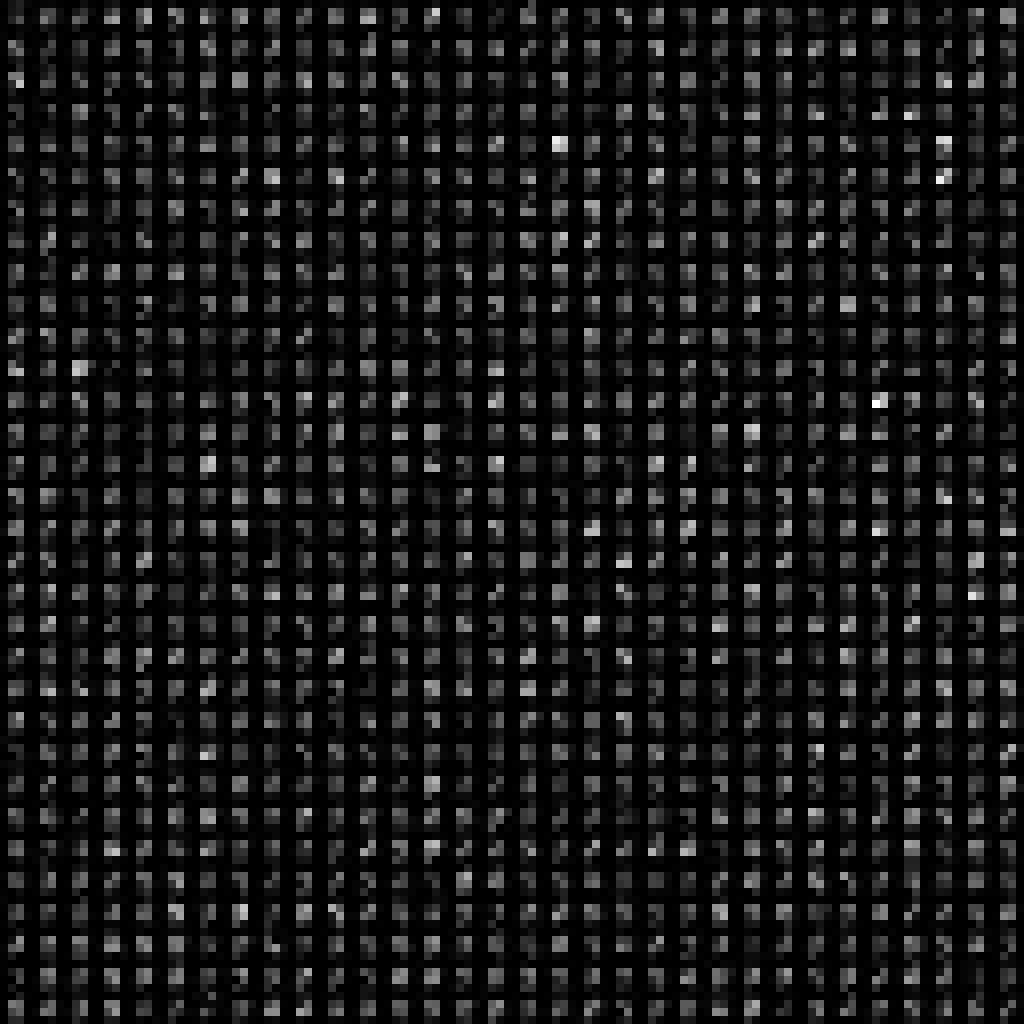

In [0]:
from IPython.display import Image
Image("results/000-pgan-mnist-preset-v2-1gpu-fp32/fakes000480.png")#, width=100, height=100)

## 3 Inference

In [0]:
model_path = 'karras2018iclr-celebahq-1024x1024.pkl'
model_path = 'results/'

In [0]:
import pickle, pickletools
import numpy as np
import tensorflow as tf
import PIL.Image

# Initialize TensorFlow session.
tf.InteractiveSession()
#sess=tf.compat.v1.InteractiveSession()


# Import official CelebA-HQ networks.
with open(model_path, 'rb') as file:
    print(file)
    
    proto_op = next(pickletools.genops(file))
    assert proto_op[0].name == 'PROTO'
    proto_ver = proto_op[1]
    print("Pickled with version", proto_ver)

    G, D, Gs = pickle.load(file)

print(Gs)

<_io.BufferedReader name='karras2018iclr-celebahq-1024x1024.pkl'>
Pickled with version 4











In [0]:
def generate_latent2image(latent):
    latents = np.asarray([latent])

    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

    # Run the generator to produce a set of images.
    images = Gs.run(latents, labels)

    # Convert images to PIL-compatible format.
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    return images[0]


latent = np.random.randn((512))
image = generate_latent2image(latent)
print(image.shape)

(1024, 1024, 3)


(1024, 1024, 3) stats: 250 0 81.36895783742268


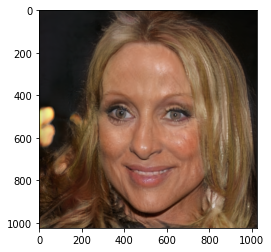

In [0]:
import matplotlib.pyplot as plt
print(image.shape, "stats:", np.max(image), np.min(image), np.mean(image))

plt.figure(figsize=(4,4))
plt.imshow(image, vmin=0.0, vmax=1.0)
plt.show()